# Outlier Detection

Haykin (1980) defined outliers (or anomalies) as 'an observation that deviates so much from 
other observations as to arouse suspicions that it was generated
by a different mechanism'. Anomaly Detection is the process of "detecting things that don't belong". As per (V Chandola, July 2009) these can be of 3 types;

> ***Point Anomalies.*** If an individual data instance can be considered as anomalous with respect to the rest of data, then the instance is termed as a point anomaly. This is the simplest type of anomaly and is the focus of majority of research on anomaly detection. A common incarnation of anomaly detection for point anomalies is in identifying outliers in data.

> ***Contextual Anomalies.*** If a data instance is anomalous in a specific context (but not otherwise), then it is termed as a contextual anomaly. The notion of a context is induced by the structure in the dataset.

> ***Collective Anomalies.*** If a collection of related data instances is anomalous
with respect to the entire data set, it is termed as a collective anomaly. The individual data instances in a collective anomaly may not be anomalies by themselves, but their occurrence together as a collection is anomalous.

Traditionally anomalies have been identified through Statistical and Visualisation means, however these fall short when used in isolation in increasingly complex environments. This is where Machine Learning can play a significant part.

In this notebook, we will attempt to detect outliers in a real-world [Credit Card Fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) used in a machine learning competition on Kaggle. It is a labelled dataset that provides 32 parameters marked as V1 to V28 and 4 other features. Due to privacy reasons the actual parameter names have been removed and replaced with generic feature names and/or derivatives of a preprocessing phase. These could possibly refer to parameters such as transaction volume, location, date and time, demographic information associated with a transaction.  

Credit card fraud is a contextual anomaly. It can be defined as a class imbalance problem where a majority of transactions are legitimate and only a few transactions are fraudulent. These fraudulent transactions exhibit different contextual and behavioural features in contrast to legitimate transactions which are difficult to define or identify using traditional methods. Thus an outlier analysis using Machine Learning becomes a viable solution.

In this notebook we are going to be looking at Anomaly detection using two  machine learning libraries; 1) sklearn and 2) PyOD .

## Setting up the Notebook



#### Installing libraries

As a first step, we will install the libraries required for this notebook to the environment.

In [1]:
# library required to connect to Google Drive to retrieve the data file
!pip install -U -q PyDrive

# python toolkit for detecting outliers
!pip install pyod             # normal install
!pip install --upgrade pyod   # or update if needed
!pip install --pre pyod       # or include pre-release version for new features

# python toolbox for combining machine learning (ML) models and scores.
!pip install combo            # normal install
!pip install --upgrade combo  # or update if needed
!pip install --pre combo      # or include pre-release version for new features

!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 4.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147473 sha256=4f96253e6ebf3c7e6a89ec0e121786b4b7187e212e8205740c20eeb48f3eb6a5
  Stored in directory: /root/.cache/pip/wheels/ea/c4/29/67ad87835b209f72e4706369c683741b09490f2829d64ea768
Successfully built pyod
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels

#### Importing libraries

In [2]:
# The following two commands ignore warnings raised due to version updates.
import warnings 
warnings.filterwarnings('ignore')

# Libraries for data processing and manipulation
import numpy as np # Used for scientific computing and efficient multi dimensional array processing
import pandas as pd # Used for data analysis and manipulation - data frames # data processing, CSV file I/O (e.g. pd.read_csv)

# For modelling
import scipy
from scipy import stats
import sklearn
from sklearn import mixture
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# For Modelling 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

from prettytable import PrettyTable
import scikitplot as skplt 
import copy 

# set seed
np.random.seed(21)

# Dimensionality reduction using TSNE
from sklearn.manifold import TSNE

# Importing KNN module from PyOD
from pyod.models.knn import KNN 
from pyod.models.ocsvm import OCSVM 

# Import the utility function for model evaluation
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.preprocessing import StandardScaler

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

# Tools for visualisation
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline 
import matplotlib.patches as mpatches
import seaborn as sns
# from cf_matrix import make_confusion_matrix 

#### Accessing the dataset 

We have hosted the dataset on a Google drive, we need to complete the familiar authentication step to download this file.

In [3]:
# Import libraries for reading the data file from the hosted location on Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# This is the file ID of the data set
dataset_file_id = '1WCnjkzqX8JtGvUjE6T7aJaLboowYcpor'

# Download the file from Google Drive
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('creditcard.csv')

Use the head() function of the data frame to visualise the first few rows of the dataset. 

Can you identify the input variables (attributes) and output/target variable (attribute) ?

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()
print(df.shape)

(284807, 31)


In [5]:
# Checking if the dataset is imbalanced or not
df.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The target (or output) variable is Class, which contains two classes, 
 

1.  Fraudulent labeled as 1 
2.  Legitimate labeled as 0

0.173% (total of 492) fraud transactions and 99.82% (total of 284,315) legitimate transactions. 

In [6]:
# We are going to set aside a single fraudulent transaction for us to use as a validator, once we have finalised our model.
df_fraudulent = df[df.Class==1]
# select one fradulent transaction
df_fraudulent = df_fraudulent.iloc[20:21]

# drop the first fradulent transaction from original dataset
df.drop(df_fraudulent.index, inplace=True)
df_fraudulent

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
6870,8757.0,-1.863756,3.442644,-4.46826,2.805336,-2.118412,-2.332285,-4.261237,1.701682,-1.439396,...,0.667927,-0.516242,-0.012218,0.070614,0.058504,0.304883,0.418012,0.208858,1.0,1


## Data Exploration

First let's visualise distribution of each feature (input attribute)  in terms of fraudulent and legitimate transactions.  


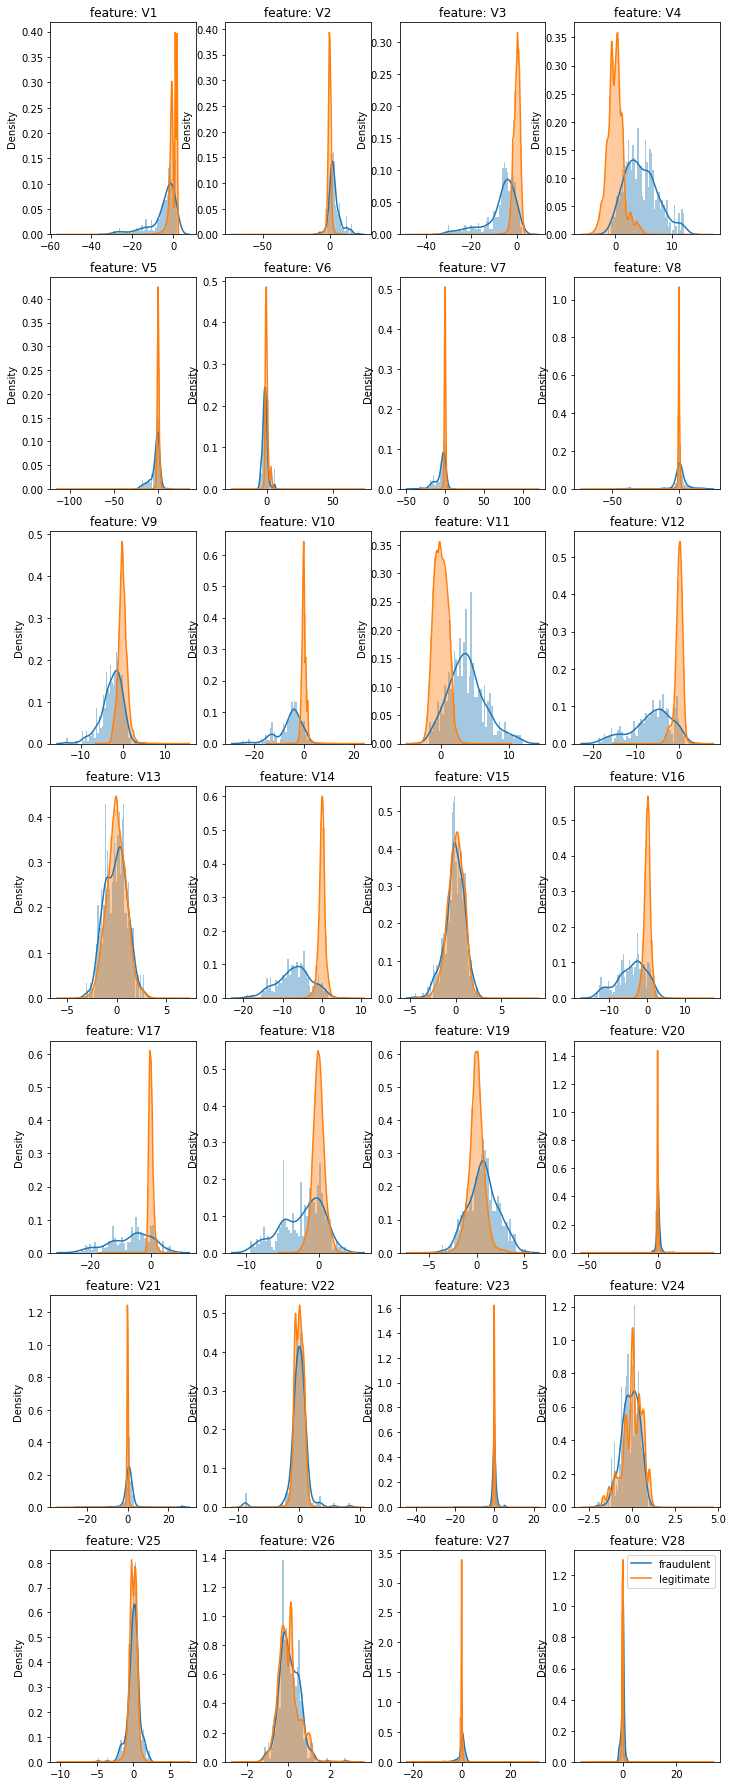

In [7]:
# Selecting the 28 features (V1 to V28) from the dataframe
v_features = df.iloc[:,1:29].columns

# Setting up the figure size and the grid space of 7x4 to plot the individual features
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)

# Iterating through each feature and plotting the distributions of fraudulent and legitimate transactions for each feature
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))

ax.legend(['fraudulent', 'legitimate'],loc='upper right')
plt.show()

Based only on this visualisation, what are your thoughts on the distribution of each input variable by the output variable?

Besides visualisation, we can also generate a correlation plot that quantifies the association of each input variable with the output variable. 


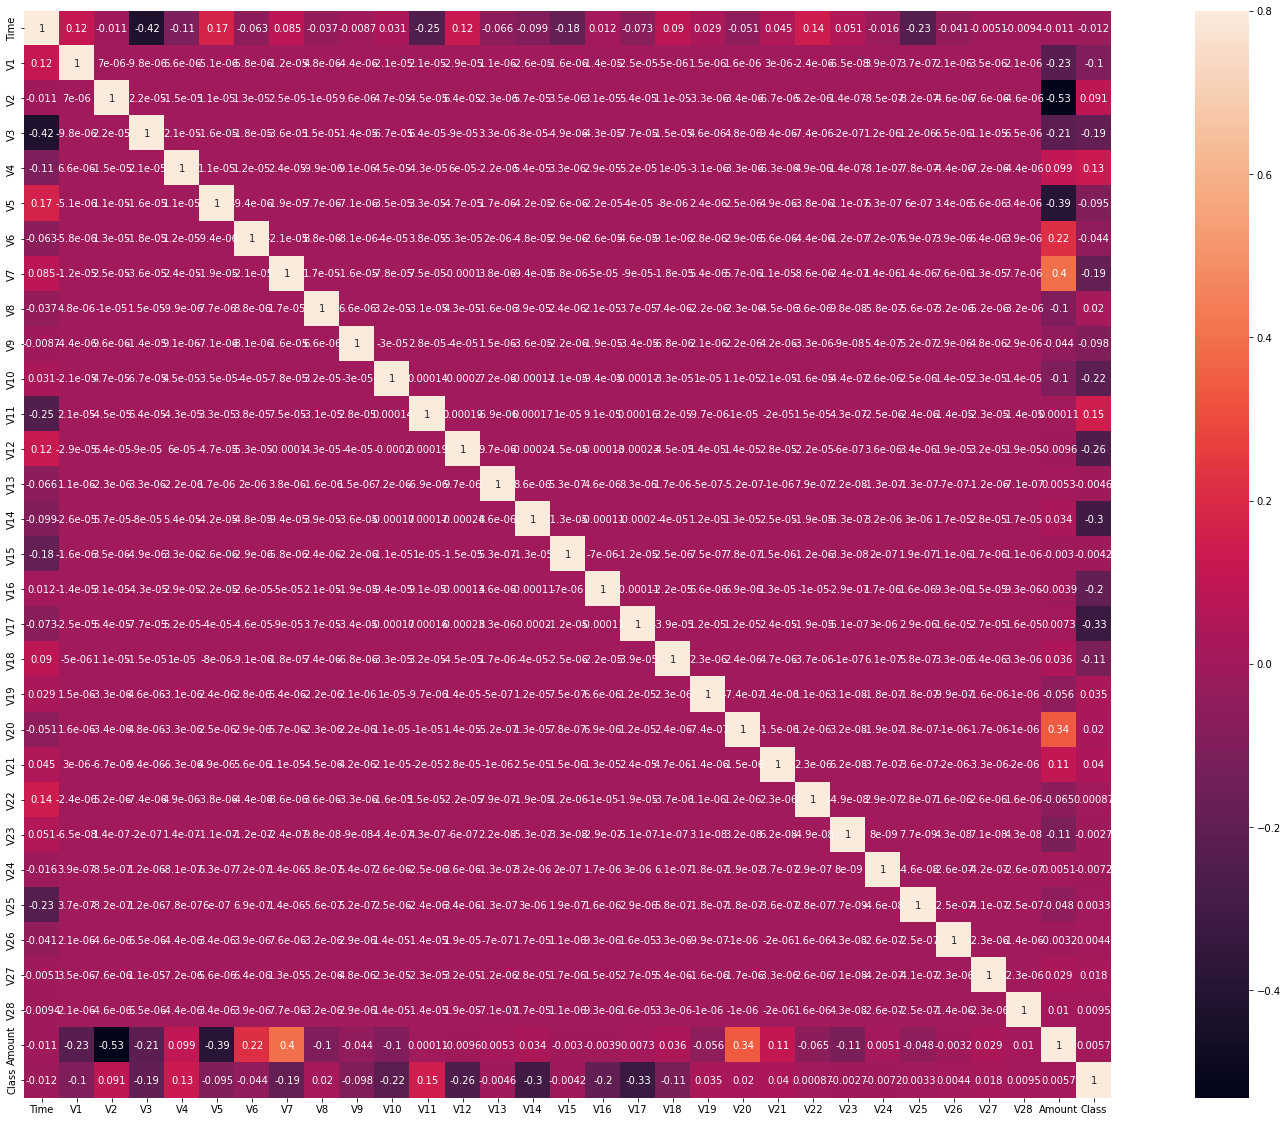

In [8]:
# find the correlation between the variables 
corr = df.corr() 
fig = plt.figure(figsize=(30,20))
sns.heatmap(corr, vmax=.8, square=True,annot=True)

What are your observations from the correlation plot? 

Which input variable has the strongest positive correlation to the output (Class) variable?

And which input variable has the strongest negative correlation to the Class variable?

 

## Supervised Learning - Using Standard Classifiers

In this section, let's attempt to build anomaly detection classifiers using  familiar supervised machine learning algorithms. 
As you will observe, only XGB produces a reasonable AUC-PR. 

In [9]:
train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print (train.shape, test.shape, validate.shape)

X_train = train.drop(columns=['Class'])
y_train = train[['Class']]

X_test = test.drop(columns=['Class'])
y_test = test[['Class']]

X_validate = validate.drop(columns=['Class'])
y_validate = validate[['Class']]

X_train.head()
y_train.head()

odLogReg = LogisticRegression()
odKNN = neighbors.KNeighborsClassifier()
odDecisionTree = tree.DecisionTreeClassifier()
odXGB = xgb.XGBClassifier()


classifiers = [ odLogReg, odKNN, odDecisionTree,  odXGB]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])

for i in classifiers:
  # Predict the class
  i.fit(X_train,y_train)
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

(170883, 31) (56961, 31) (56962, 31)
+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|   LogisticRegression   |  0.999   |  0.673   |     0.907     |  0.636   |
|  KNeighborsClassifier  |  0.998   |  0.054   |     0.596     |  0.057   |
| DecisionTreeClassifier |  0.999   |  0.758   |      0.87     |  0.576   |
|     XGBClassifier      |   1.0    |  0.853   |     0.981     |  0.845   |
+------------------------+----------+----------+---------------+----------+


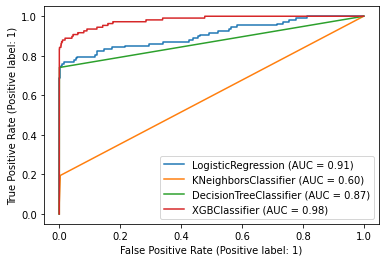

In [10]:
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=all_axes)

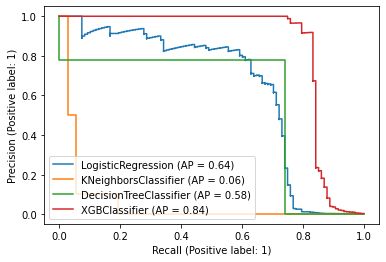

In [11]:
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_test, y_test, ax=all_axes)

## Unsupervised Learning - Using GMM

Gaussian Mixture Model (GMM) as its name would indicate involves the superimposition of multiple Gaussian distributions, so rather than identifying clusters by the nearest centroid as we would do in traditional k-means clustering we fit a set of k-gaussians to the data. 

Or rather simply, k-means is a hard clustering (unsupervised learning) algorithm which assigns each data point to only one cluster, while GMM is soft clustering, which generates the likelihood of a data point being generated by k distribution, for each k-gaussian. 

Then we estimate the Gaussian distribution parameters such as mean and variance for each cluster. Every distribution is multiplied by a weight to account for the fact that we do not have an equal number of samples from each category. Then for each data point we calculate the probabilities of belonging to each of the clusters.   

### Data - Training, Validation, and Testing sets 

Given that the dataset is imbalanced with a majority of the transactions denoting legitimate transactions and small minority labelled as fraudulent transactions, we will need to approach the model building exercise slightly differently.

Our approach will be to first train our Gaussian Mixture Model on all the legitimate transactions and then validate the probability of a transaction being fraudulent looking at the probability that that transaction belongs to the Gaussian mixture. We would evaluate this by defining a threshold.

Towards this end we will split our dataset to facilitate *Training the Model, Validating a Threshold, and Testing*. 

**Training the Model** - All legitimate transactions,
90% for training + 10% for testing and cross validation. This is one of the standard ratios used for machine learning.

**Validating a Threshold**
50% of the fraudulent transactions

**Testing**
The remaining 50% of the fraudulent transactions.

### Model 1 - GMM with all input variables

During the data exploration, we discovered two variables are highly correlated to the Class variable, however, GMM is powerful enough to accommodate all the variables in the same model. Let's try that first. 



In [12]:
df_0=df[df.Class==0] # legitimate transactions
df_1=df[df.Class==1] # fraudulent transactions

# Using legitimate transactions - 90% for training the GMM and 10% for cross-validation and testing
X_train, X_test, y_train, y_test = train_test_split(df_0.drop(['Class'],axis=1), df_0['Class'] , test_size=0.1, random_state=0)

# Using fraudulent transactions - 50% for cross-validation and 50% for testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1.drop(['Class'],axis=1), df_1['Class'] , test_size=0.5, random_state=0)

# Fit a Gaussian Mixture Model
clf_all = mixture.GaussianMixture()
clf_all.fit(X_train)

GaussianMixture()

#### Selecting the probability threshold

*   Threshold value is crucial to separate fraudulent transactions from legitimate transactions.
*   Let's try the standard practice of the number of standard deviations from the mean to identify the threshold.
* 99.7% of the values of a gaussian distribution resides within 3 standard deviations from the mean. Let's go with this.
* We can visualise the threshold value on a plot of the predicted probabilities for the test dataset.



Value of T  -291.84517799871446


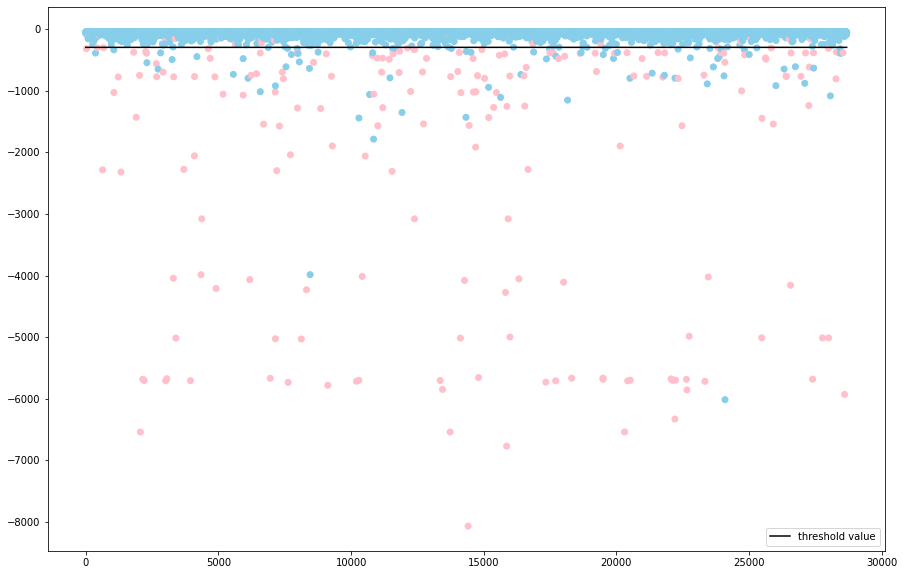

In [13]:
scores = clf_all.score_samples(X_train)
T = scores.mean() - 3* scores.std() 
print("Value of T ",T)
y_test_proba_all = clf_all.score_samples(np.vstack([X_test, X_test_1]))

f, ax = plt.subplots(1, 1, figsize = (15, 10))
ytest = y_test.values.tolist() + y_test_1.values.tolist()
y_test_proba_sff, ytest_sff = shuffle(y_test_proba_all, ytest, random_state=22)

plt.scatter(range(len(y_test_proba_sff)), y_test_proba_sff, c=['pink' if x == 1 else 'skyblue' for x in ytest_sff])
plt.plot(range(len(y_test_proba_sff)), [T] * len(y_test_proba_sff), linestyle='-', c='k', label='threshold value') # solid line indicates the threshold value
plt.legend(loc="lower right")

plt.show()

#### Evaluating performance

Now that the GMM has been trained let's find the probabilities of the test set.

Once a probability threshold has been established if the probability of a record is below that threshold then it is likely to be a fraudulent transaction (because our GMM is modelled on legitimate transactions). 

We can see how the performance of the model will change as we tune the value of the threshold T that we have defined above. Lower probability thresholds provides better AUC.



Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.72      0.76      0.74       246

    accuracy                           1.00     28678
   macro avg       0.86      0.88      0.87     28678
weighted avg       1.00      1.00      1.00     28678

Test AUCPR = 0.5471857865793036


Text(0.5, 1.0, 'Precision-Recall curve: AUC=0.55')

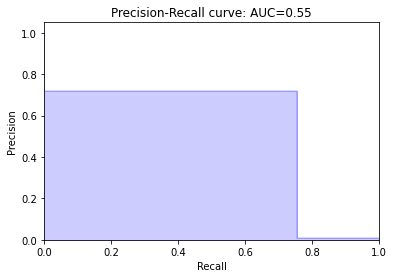

In [14]:
y_test_proba_all[y_test_proba_all>=T]=0
y_test_proba_all[y_test_proba_all<T]=1

y_test_orig=np.hstack([y_test, y_test_1])
print('Classification report')
print(classification_report(y_test_orig, y_test_proba_all))
print('Test AUCPR = ' + str(average_precision_score(y_test_orig, y_test_proba_all)))

precision, recall, _ = precision_recall_curve(y_test_orig, y_test_proba_all)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test_orig, y_test_proba_all)))

### Model 2 - GMM with most correlated input variables

Here we use the two most correlated features which are V14 and V17 to build a second GMM.

Value of T:  -14.463164394119389


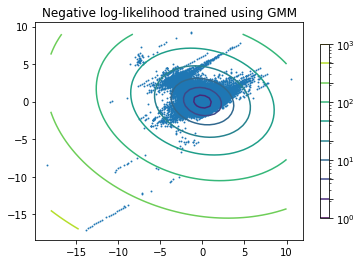

In [15]:
df_0=df[df.Class==0] # legitimate transactions
df_1=df[df.Class==1] # fraudulent transactions

df_0=df_0[['V14', 'V17','Class']] # Select two most correlated features for now
df_1=df_1[['V14', 'V17', 'Class']]

# Split non-fraudulent data in 90% for training GMM and 10% for cross-validation and testing
X_train, X_test, y_train, y_test = train_test_split(df_0.drop(['Class'],axis=1), df_0['Class'] , test_size=0.1, random_state=0)
# Split the fraudulent data in 50% for cross-validation and 50% for testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1.drop(['Class'],axis=1), df_1['Class'] , test_size=0.5, random_state=0)

# Fit a Gaussian Mixture Model with the two components 'V14' and 'V17'
clf_selected = mixture.GaussianMixture()
clf_selected.fit(X_train)

scores = clf_selected.score_samples(X_train)
T = scores.mean() - 3 * scores.std()  # try -40
print("Value of T: ",T)
# Display predicted scores by the model as a contour plot
x = np.linspace(-18, 10)
y = np.linspace(-17, 9.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf_selected.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train['V14'].values,X_train['V17'].values, 0.8)
plt.title('Negative log-likelihood trained using GMM')
plt.axis('tight')
plt.show()

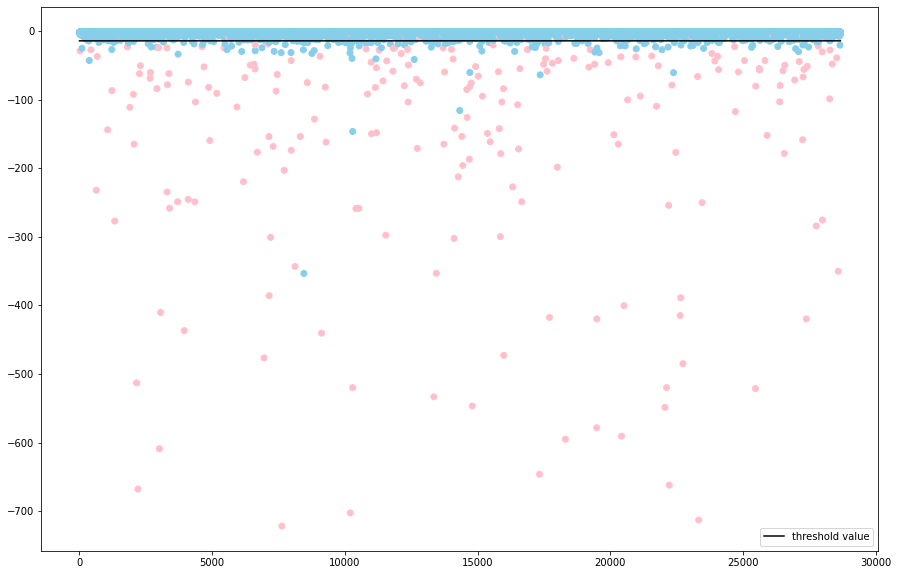

In [16]:
y_test_proba = clf_selected.score_samples(np.vstack([X_test, X_test_1]))

f, ax = plt.subplots(1, 1, figsize = (15, 10))
ytest = y_test.values.tolist() + y_test_1.values.tolist()
y_test_proba_sff, ytest_sff = shuffle(y_test_proba, ytest, random_state=22)

plt.scatter(range(len(y_test_proba_sff)), y_test_proba_sff, c=['pink' if x == 1 else 'skyblue' for x in ytest_sff])
plt.plot(range(len(y_test_proba_sff)), [T] * len(y_test_proba_sff), linestyle='-', c='k', label='threshold value') # solid line indicates the threshold value
plt.legend(loc="lower right")
plt.show()

You will notice that some records have very low probabilities, which are likely to be anomalies.

#### Evaluating performance

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.60      0.83      0.70       246

    accuracy                           0.99     28678
   macro avg       0.80      0.91      0.85     28678
weighted avg       1.00      0.99      0.99     28678

Test AUCPR = 0.5019696606703898


Text(0.5, 1.0, 'Precision-Recall curve: AUC=0.50')

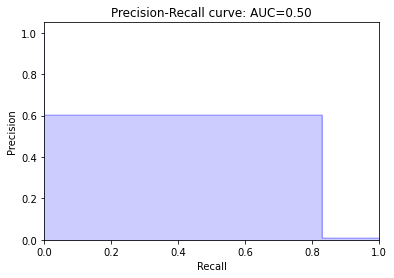

In [17]:
y_test_proba[y_test_proba>=T]=0
y_test_proba[y_test_proba<T]=1

y_test_orig=np.hstack([y_test, y_test_1])
print('Classification report')
print(classification_report(y_test_orig, y_test_proba))
print('Test AUCPR = ' + str(average_precision_score(y_test_orig, y_test_proba)))

precision, recall, _ = precision_recall_curve(y_test_orig, y_test_proba)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test_orig, y_test_proba)))

#### Evaluating a new transaction

Let's evaluate a new transaction on the trained model.

In [18]:
transaction_without_class = df_fraudulent[['V14', 'V17']]
scores = clf_selected.score_samples(transaction_without_class.values)

# Since we have only selected a single fraudulent transaction, comparing the threshold with the score at the first index
print("Threshold value is " + str(T))
print("Score value is " + str(scores[0]))

if scores[0] < T:
  print("The transaction is fraudulent")
else:
  print("The transaction is legitimate")

Threshold value is -14.463164394119389
Score value is -84.29360827211667
The transaction is fraudulent


#### Building out a simple application which uses our newly trained model

Now we have a trained model, how can we use it in an application. Here we demonstrate a simple form application which accepts two attributes V14 and V17 for a transaction and then evaluates the transaction for its legitimacy.

In [19]:
#@title Transaction Investigator v0.1

V14 = '45' #@param {type:"string"}
V17 = '-2.760097' #@param {type:"string"}

transaction = np.array([float(V14), float(V17)]).reshape(1, -1)
scores = clf_selected.score_samples(transaction)

#Since we have only selected a single fraudulent transaction, comparing the threshold with the score at the first index
print("Threshold value is " + str(T))
print("Score value is " + str(scores[0]))

if scores[0] < T:
  print("The transaction is fraudulent")
else:
  print("The transaction is legitimate")

Threshold value is -14.463164394119389
Score value is -1264.0247272550075
The transaction is fraudulent


## Using the PyOD library

GMM is one method of detecting anomalies, but there are many others unsupervised learning algorithms. 

PyOD is a more comprehensive and scalable Python toolkit for detecting anomalies/outliers in multivariate data. It has around 20 outlier detection algorithms (supervised and unsupervised). PyOD is developed with a comprehensive API to support multiple techniques and you can take a look at the official documentation of PyOD [here](https://pyod.readthedocs.io/). 

Let's explore several algorithms in PyOD to identify the anomalies which have provided different levels of accuracy measures. 

### A Subset of the Dataset

As the dataset is highly imbalanced, we use the simplest undersampling method (decreasing the size of the majority class) by limiting to 10,000 valid cases and all 492 fraud cases.

In [20]:
positive = df[df["Class"]== 1]
negative = df[df["Class"]== 0]
new_df = pd.concat([positive,negative[:10000]])

# shuffling the new subset 
new_df = new_df.sample(frac=1,random_state=42)

Let's remove Time and Class attributes as we are using an unsupervised learning approach to identify the anomalies. 

In [21]:
# split into independent variables and target variable
X = new_df.drop(['Time','Class'], axis=1) 
y = new_df['Class']  

# show the shape of x and y  
print("X shape: {}".format(X.shape)) 
print("y shape: {}".format(y.shape))

X shape: (10491, 29)
y shape: (10491,)


In [22]:
# split the data into train and test 
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=42)

### K-Nearest Neighbors (KNN)

Let's start with K-Nearest Neighbours (kNN), which is one of the simplest machine learning algorithms.
Using KNN, for any observation, its distance to its kth nearest neighbor could be viewed as the outlying score.

PyOD supports three kNN detectors

* Largest: Uses the distance of the kth neighbor as the outlier score.
* Mean: Uses the average of all k neighbors as the outlier score.
* Median: Uses the median of the distance to k neighbors as the outlier score.


We are going to fit the training dataset to form the KNN clustering model.

In [23]:
# create the KNN model
clf_knn = KNN(contamination=0.34, n_neighbors = 5, n_jobs=-1)
clf_knn.fit(X_train)

KNN(algorithm='auto', contamination=0.34, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [24]:
# Get the prediction labels of the training data 
y_train_pred = clf_knn.labels_ # binary labels (0: inliers, 1: outliers) 

# Outlier scores 
y_train_scores = clf_knn.decision_scores_ 

PyOD provides a useful function for this task called evaluate_print(). The default metrics include ROC and Precision. We will pass class name, y_train values and y_train_scores to evaluate the model performance on training set.

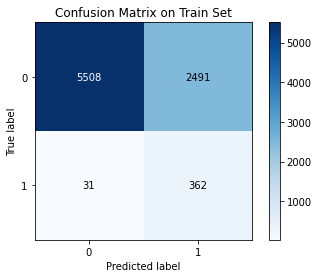

In [25]:
# plot the confusion matrix for the training dataset 
skplt.metrics.plot_confusion_matrix(y_train, y_train_pred, normalize=False, title="Confusion Matrix on Train Set")
plt.show()

Evaluating the KNN model on the test dataset.

KNN ROC:0.8761, precision @ rank n:0.4082


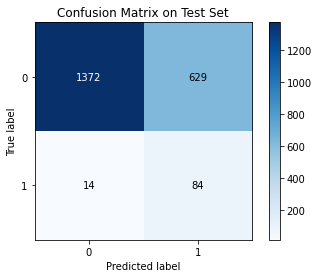

In [26]:
y_test_scores = clf_knn.decision_function(X_test)  # outlier scores

# Evaluate on the training data
evaluate_print('KNN', y_test,y_test_scores)

# plot the confusion matrix in the test set
y_preds = clf_knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title="Confusion Matrix on Test Set",)
plt.show()

In [27]:
# classification report
y_predict = clf_knn.predict(X_test)
classreport = metrics.classification_report(y_test,y_predict)
print(classreport)

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      2001
           1       0.12      0.86      0.21        98

    accuracy                           0.69      2099
   macro avg       0.55      0.77      0.51      2099
weighted avg       0.95      0.69      0.78      2099



### Supervised Learning Classifiers on the Subset

Here we compare how the supervised learning models perform on the subset compared to the original (highly imbalanced) dataset.  

In [28]:
odLogReg = LogisticRegression()
odDecisionTree = tree.DecisionTreeClassifier()
odKNN = neighbors.KNeighborsClassifier()
odXGB = xgb.XGBClassifier()

classifiers = [ odLogReg, odDecisionTree, odKNN, odXGB]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])

for i in classifiers:
  # Predict the class
  i.fit(X_train,y_train)
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|   LogisticRegression   |   0.99   |  0.881   |     0.982     |  0.923   |
| DecisionTreeClassifier |  0.986   |  0.851   |      0.92     |  0.732   |
|  KNeighborsClassifier  |  0.987   |   0.84   |     0.906     |  0.808   |
|     XGBClassifier      |  0.992   |  0.906   |      0.99     |  0.944   |
+------------------------+----------+----------+---------------+----------+


### Unsupervised Learning - t-SNE

Dimension reduction techniques, such as self-organizing map (SOM), t-distributed stochastic neighbour embedding (t-SNE) can be used to project large  number of dimensions into two dimensions while preserving the existing relationships between datapoints. This projection is then used to determine outliers. 

Let's try t-SNE.

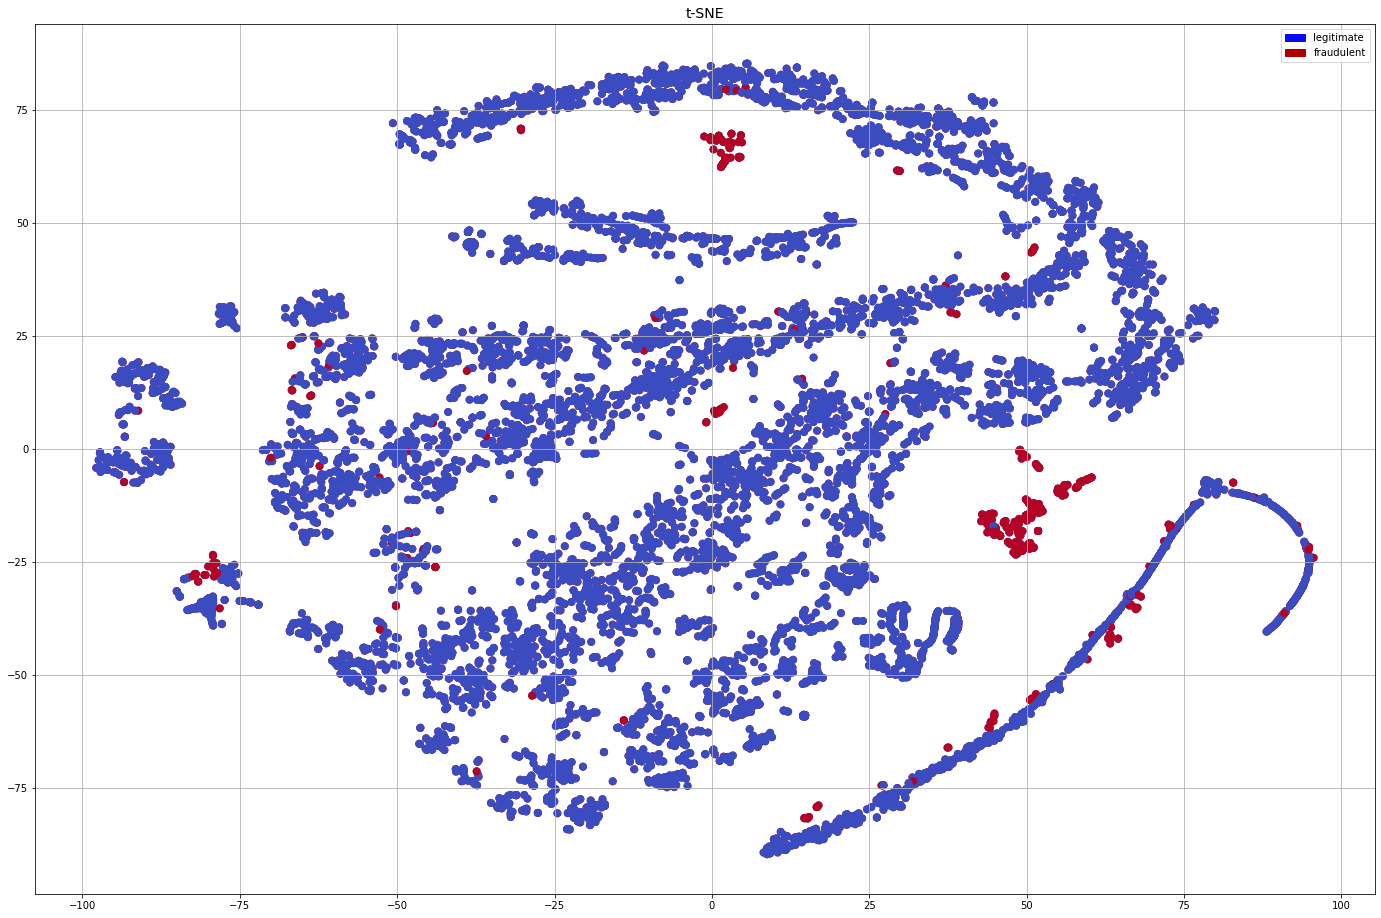

In [29]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='legitimate')
red_patch = mpatches.Patch(color='#AF0000', label='fraudulent')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='legitimate', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='fraudulent', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])
plt.show()

X = X_reduced_tsne

### More Unsupervised Learning 

PyOD has many sophisticated unsupervised machine learning algorithms  for anomaly detection. Visualizing decision boundraries will provide more insights into the identified anomalies and how they have spread across the non-fradulent data points. Let's explore the following algorithms: 

* Angle-based Outlier Detector (ABOD)
* Feature Bagging
* Histogram-base Outlier Detection (HBOS)
* Isolation Forest
* K Nearest Neighbors (KNN)
* Average KNN
* Local Outlier Factor (LOF)
* Minimum Covariance Determinant (MCD)
* One-class SVM (OCSVM)
* Principal Component Analysis (PCA)
* Locally Selective Combination (LSCP)

(10491, 2)
(491,)
No of Errors :  Angle-based Outlier Detector (ABOD) 491
No of Errors :  Feature Bagging 801
No of Errors :  Histogram-base Outlier Detection (HBOS) 883
No of Errors :  Isolation Forest 934
No of Errors :  K Nearest Neighbors (KNN) 764
No of Errors :  Average KNN 598
No of Errors :  Local Outlier Factor (LOF) 814
No of Errors :  Minimum Covariance Determinant (MCD) 948
No of Errors :  One-class SVM (OCSVM) 946
No of Errors :  Principal Component Analysis (PCA) 952
No of Errors :  Locally Selective Combination (LSCP) 1006


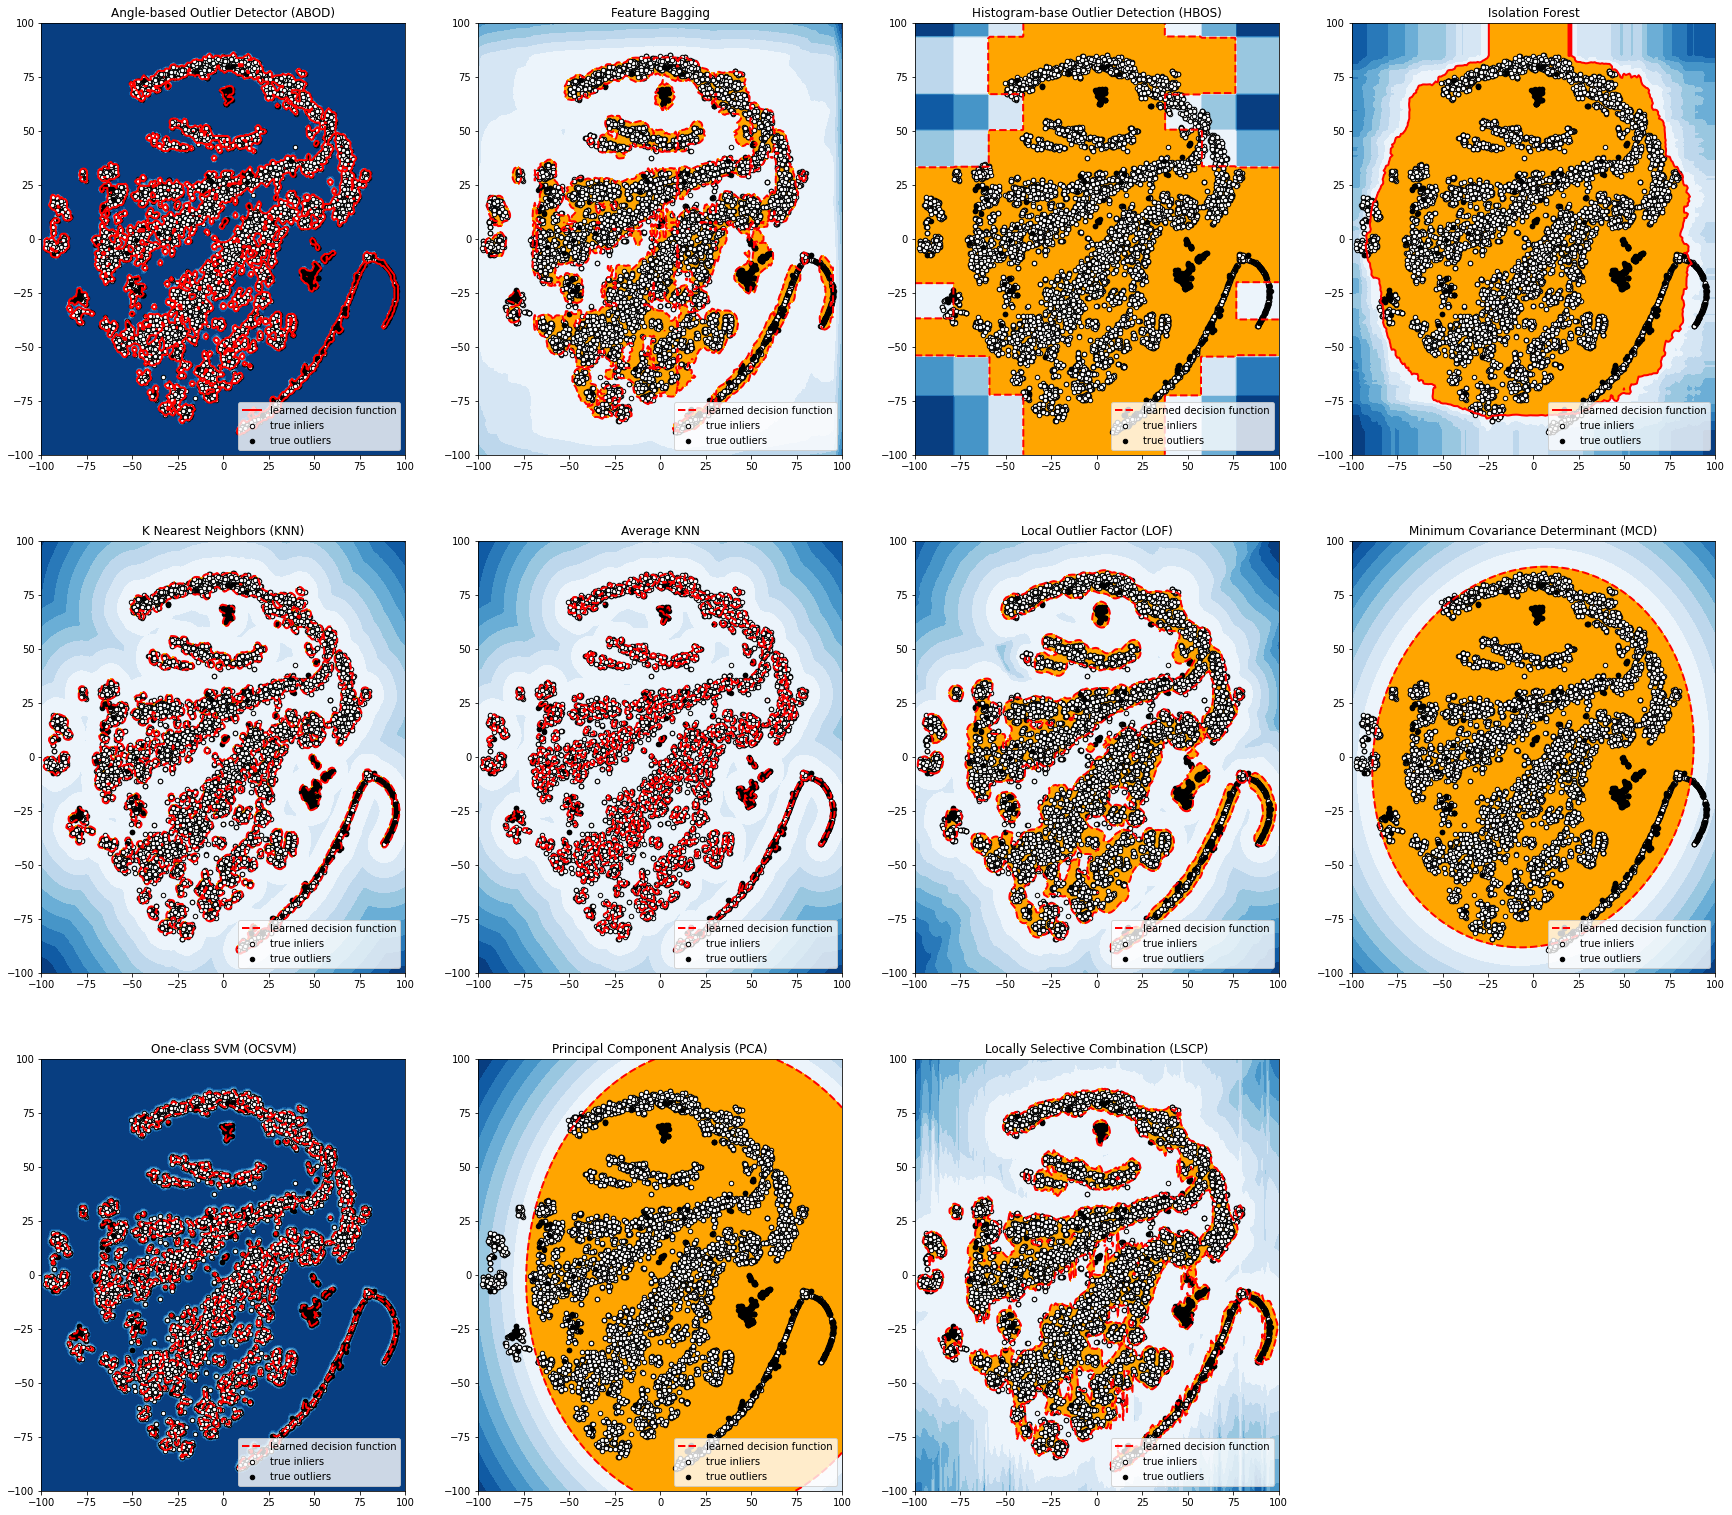

In [30]:
outliers_fraction = 0.05

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

X = X_reduced_tsne
print(X.shape)
xx , yy = np.meshgrid(np.linspace(-100, 100 , 200), np.linspace(-100, 100, 200))
indices_0 = np.where(y == 0)[0]
indices_1 = np.where(y == 1)[0]

elements_0 = (np.take(X, indices_0, 0))
elements_1 = (np.take(X, indices_1, 0))

print(indices_1.shape)
plt.figure(figsize=(30, 27))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)

    # no of errors in prediction
    n_errors = (y_pred != y).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(3, 4, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(elements_0[:,0], elements_0[:,1], c='white', s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(elements_1[:,0], elements_1[:,1], c='black', s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-100, 100))
    subplot.set_ylim((-100, 100))
plt.show() 



### References


D. M. Hawkins, Identification of outliers, Vol. 11, Springer, 1980.

Chandola, V., Banerjee, A., & Kumar, V. (2009). Anomaly detection: A survey. ACM computing surveys (CSUR), 41(3), 1-58.
